In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

In [2]:
class EventSequence:
    """
    用户定义的事件序列。
    通过检查元素的类型（字符串或数字）来解析序列，允许任意顺序。
    """
    def __init__(self, ops: dict, sequence: list):
        """
        初始化事件序列。
        :param ops: 操作字典, e.g., {'U_pi_YY': op1, 'U_XX': op2}。
        :param sequence: 灵活的事件序列列表, e.g., [1, 'U_pi_YY', 1] 或 ['U_pi_YY', 1, 'U_XX', 1]。
        """
        self.ops = ops
        self.sequence = sequence

    def generate_events(self, t_total: float) -> list[dict]:
        """
        根据给定的 t_total 和灵活的序列生成事件列表。
        :param t_total: 当前演化的总时间。
        :return: 事件列表, 每个事件是一个字典。
        """
        events = []
        current_time = 0.0

        # 首先，计算总的相对时间单位，用于缩放
        total_time_units = sum(item for item in self.sequence if isinstance(item, (int, float)))
        
        if total_time_units == 0:
            time_unit_duration = 0
        else:
            time_unit_duration = t_total / total_time_units

        # 遍历序列，根据类型处理每个元素
        for item in self.sequence:
            if isinstance(item, str):  # 如果是字符串，则为操作
                op_name = item
                if op_name not in self.ops:
                    raise KeyError(f"操作 '{op_name}' 在提供的操作字典中未找到。")
                op = self.ops[op_name]
                # 在当前时间点添加一个脉冲事件
                events.append({'time': current_time, 'op': op, 'type': 'unitary'})

            elif isinstance(item, (int, float)):  # 如果是数字，则为时间间隔
                relative_interval = item
                # 时间前进相应的比例
                current_time += relative_interval * time_unit_duration
            
            else:
                raise TypeError(f"序列中的元素 '{item}' 必须是字符串（操作名）或数字（时间间隔）。")
        
        return events


In [16]:
# --- 3. 演化和模拟函数 (无变化) ---
def evolve_density_matrix(H, rho0, t_total, events, c_ops, options, eps=1e-9):
    current_rho = rho0
    boundaries = sorted(set([0.0] + [e['time'] for e in events] + [t_total]))
    unique_boundaries = []
    if boundaries:
        unique_boundaries.append(boundaries[0])
        for t in boundaries[1:]:
            if t - unique_boundaries[-1] > eps:
                unique_boundaries.append(t)
    
    for i in range(len(unique_boundaries) - 1):
        t0, t1 = unique_boundaries[i], unique_boundaries[i + 1]
        for e in events:
            if abs(e['time'] - t0) < eps and e['type'] == 'unitary':
                current_rho = e['op'] * current_rho * e['op'].dag()
        if abs(t1 - t0) > eps:
            result = mesolve(H, current_rho, [0, t1 - t0], c_ops, e_ops=[], options=options)
            current_rho = result.states[-1]
    for e in events:
        if abs(e['time'] - t_total) < eps and e['type'] == 'unitary':
             current_rho = e['op'] * current_rho * e['op'].dag()
    return current_rho

def run_dynamic_simulation_v5(evolution_times, ops, observables, c_ops, event_sequence, options,
                              N_samples=100, sigma_noise=0.1 * np.pi):
    results = np.zeros((len(observables), len(evolution_times)))
    H_base = (1 * np.pi / 2.0) * (ops['sz1'] + ops['sz2']) + \
             (0.2 * np.pi / 2.0) * (ops['P01'] - ops['P10'])
    H_noise_op = 0.1*(ops['sz1'] + ops['sz2']) / 2.0
    rho0 = ops['psi_p_initial'] * ops['psi_p_initial'].dag()
    for i, t_total in enumerate(tqdm(evolution_times, desc="演化时间扫描")):
        avg_vals = np.zeros(len(observables))
        for _ in range(N_samples):
            eps_k = np.random.normal(0, sigma_noise)
            H = H_base + eps_k * H_noise_op
            events_with_pulses = event_sequence.generate_events(t_total)
            rho = evolve_density_matrix(H, rho0, t_total, events_with_pulses, c_ops, options)
            for j, obs in enumerate(observables):
                avg_vals[j] += expect(obs, rho)
        results[:, i] = avg_vals / N_samples
    return results

In [17]:
g, e = basis(2, 0), basis(2, 1)
ge, eg = tensor(g, e), tensor(e, g)
gg = tensor(g, g)
psi_plus = (ge + eg).unit()

ops = {
    'sx1': tensor(sigmax(), qeye(2)),
    'sy1': tensor(sigmay(), qeye(2)),
    'sz1': tensor(sigmaz(), qeye(2)),
    'sx2': tensor(qeye(2), sigmax()),
    'sy2': tensor(qeye(2), sigmay()),
    'sz2': tensor(qeye(2), sigmaz()),
    'P01': ge * ge.dag(),
    'P10': eg * eg.dag(),
    'U_pi_YY': tensor(gates.ry(np.pi), gates.ry(np.pi)),
    'U_halfpi_YY': tensor(gates.ry(0.5*np.pi), gates.ry(0.5*np.pi)),
    'U_XX': tensor(gates.rx(0.5*np.pi), gates.rx(0.5*np.pi)), # 添加一个示例操作
    'psi_p_initial': gg,
    'P_psi_plus': psi_plus * psi_plus.dag()
}

自旋回波序列: ['U_halfpi_YY', 1, 'U_pi_YY', 1, 1, 'U_pi_YY', 1, 1, 'U_pi_YY', 1, 1, 'U_pi_YY', 1, 1, 'U_pi_YY', 1, 'U_halfpi_YY']
Ramsey 序列: ['U_halfpi_YY', 1, 'U_halfpi_YY']
同时脉冲序列: ['U_pi_YY', 'U_XX', 1]

正在运行模拟...


演化时间扫描: 100%|██████████| 201/201 [00:15<00:00, 12.70it/s]


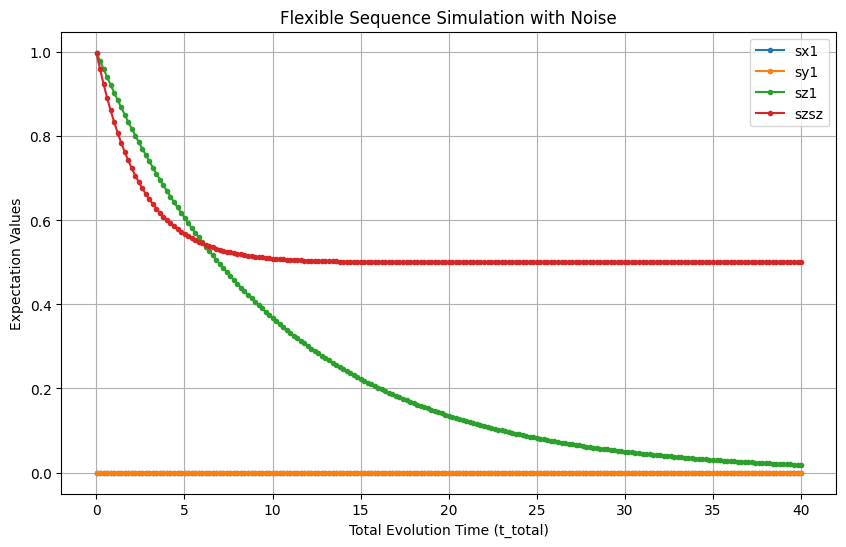

In [19]:


# --- 示例：使用新的灵活序列 ---
# 示例 1: 传统的自旋回波 (N=5)
# [脉冲, 等待, 脉冲, 等待, ...]
spin_echo_sequence = ['U_halfpi_YY']
for _ in range(5):
    spin_echo_sequence.append(1)
    spin_echo_sequence.append('U_pi_YY')
    spin_echo_sequence.append(1)
spin_echo_sequence.append('U_halfpi_YY')
print(f"自旋回波序列: {spin_echo_sequence}")
S_spin_echo = EventSequence(ops, sequence=spin_echo_sequence)

# 示例 2: Ramsey 实验序列
# [等待 tau/2, 脉冲, 等待 tau/2]
ramsey_sequence = ['U_halfpi_YY',1,'U_halfpi_YY']
print(f"Ramsey 序列: {ramsey_sequence}")
S_ramsey = EventSequence(ops, sequence=ramsey_sequence)

# 示例 3: 两个脉冲同时作用，然后等待
simultaneous_pulse_sequence = ['U_pi_YY', 'U_XX', 1]
print(f"同时脉冲序列: {simultaneous_pulse_sequence}")
S_simultaneous = EventSequence(ops, sequence=simultaneous_pulse_sequence)


# --- 选择一个序列来运行模拟 ---
# 您可以在这里切换 S_spin_echo, S_ramsey, S_simultaneous 来测试不同的序列
chosen_sequence =S_spin_echo
print("\n正在运行模拟...")


obs_list = [ops['sx1'], ops['sy1'], ops['sz1'], tensor(sigmaz(), sigmaz())]
evolution_times = np.linspace(0.01, 40.0, 201) # 减少时间范围以便更快看到结果
c_ops = [np.sqrt(0.05) * (ops['sz1'] + ops['sz2'])]

results = run_dynamic_simulation_v5(evolution_times, ops, observables=obs_list, c_ops=c_ops,
                                    event_sequence=chosen_sequence,
                                    options={'store_states': True, 'nsteps': 50000},
                                    N_samples=10) # 使用较少的样本数以加快测试速度

# 绘图
plt.figure(figsize=(10, 6))
for i, label in enumerate(["sx1", "sy1", "sz1", "szsz"]):
    plt.plot(evolution_times, results[i, :], '.-', label=label)

plt.xlabel("Total Evolution Time (t_total)")
plt.ylabel("Expectation Values")
plt.title("Flexible Sequence Simulation with Noise")
plt.legend()
plt.grid(True)
plt.show()